**Instructions:**

1. Make sure you submit the solutions before the deadline (Sunday May 5, 2024 by midnight). Late submission will be penalized as follows: late within one day (24 hours): 15% penalty; late within two days: 30% penalty, late within three days: 40% penalty. Submission after three days will not be accepted.

2. Discussion with classmates on the problems is not allowed. All clarification questions should be directed to me. You should be responsible for the debugging of the code. I have provided a lot of check points to help you gain confidence of your code.

3. Make sure you rerun the whole Jupyter file one last time before submission. When I grade your code, I will run the code from scratch, and I will grade based on what I get. It happens sometimes that you unintentionally change some code that has been debugged and re-introduce some bugs. Rerunnning the whole code one final time before submission prevents that happening.

4. After you submit your code, it is your responsibility to check if you submitted the correct file. Sometimes an empty file is submitted by mistake. I will treat any resubmissions past the deadline that are due to such mistakes as late submissions.

5. Please utilize the time wisely. Do not wait until the last minute to work the problems.

6. The data files needed are: 'movie_ids.txt', 'movieParams.mat' and 'movies.mat'.

Hope you enjoy the project and good luck! 

**Score distributions**:

|Parts     | Points  |
|----------|---------|
|Part 1a   | 5 pts   |
|Part 1b   | 5 pts   |
|Part 2    | 10 pts  |
|Part 3    | 10 pts  |
|Part 4    | 10 pts  |
|Part 5    | 10 pts  |
|Part 6a   | 5 pts   |
|Part 6b   | 5 pts   |
|Part 7    | 10 pts  |
|Part 8a   | 5 pts   |
|Part 8b   | 5 pts   |
|Part 9    | 15 pts  |
|Part 10   | 5 pts   |
|Total     | 100 pts |

In [1]:
from scipy.io import loadmat
import numpy as np
from scipy.optimize import approx_fprime
from scipy.optimize import fmin_cg
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
%matplotlib inline

# Final Project -- Building a Movie Recommendation System

In this project, you will learn to build a recommendation system using a technique called **Collaborative Filtering**. You will see two different ways to implment the algorithm, which can provide somewhat different results. The first one is named **Matrix Factorization** and the second one is based on **nearest neighbors**. You will be guided in great detail to implement the two methods.

## Backgroud

Movie ratings on a scale of 1 to 5 have been collected from 943 users of a review-aggregation website for 1682 movies ($n_u=943$, $n_m=1682$). The ratings are sparse, which means each user only gives ratings to the movies they watched. We would like to develop an algorithm that can predict the ratings to all the movies a user did not rate, so we can recommend movies to the user based on the largest predicted ratings.

Related data files: 'movie.mat' containing the matrices $Y$ and $R$ to be explained below, 'movieParams.mat' containing some pretrained parameters to be explained, and 'movie_idx.txt' containing the names and years of all the 1682 movies.

## Part 1--Load the data 

Load 'movies.mat'. You will see there are two matrices: $Y$ ($n_m\times n_u$) and $R$ ($n_m\times n_u$). 

The matrix $Y$ contains the ratings (1 to 5), where each element $y_{ij}$ represents the rating to movie $i$ by user $j$, so each row of the matrix represents all the ratings to a particular movie by all the users, and each column of the matrix represents all the ratings given by a particular user. If $y_{ij}=0$, then it means movie $i$ was not rated by user $j$.

The matrix $R$ is an binary-valued indicator matrix (mask matrix), where $R_{ij}=1$ if user $j$ gave a rating to movie $i$, and $R_{ij}=0$ otherwise. 

To get a better understanding of the data, let's do the following steps: 

**Part 1a (5 pts)**: Draw a histogram of the number of movies a user rated, i.e., use matrix $R$ to find $n_u$ numbers, each representing the number of movies a user rated, and plot the histogram of the $n_u$ numbers. You should see most users rated a small number of movies.

**Part 1b (5 pts)**:  Compute the average movie rating for the first movie--Toy Story with the np.mean function (Note that the average rating should be ONLY calculated with the ratings that are greater than 0. A zero value in $Y$ means no rating was given and should not be counted in the averaging.) in two ways: 1) Use Only $Y$; 2) Use $Y$ and $R$, where $R$, after converted to bool type, can be used to select the numbers (columns) in $Y$ that will be used for averaging. You should get the same average with the two methods.

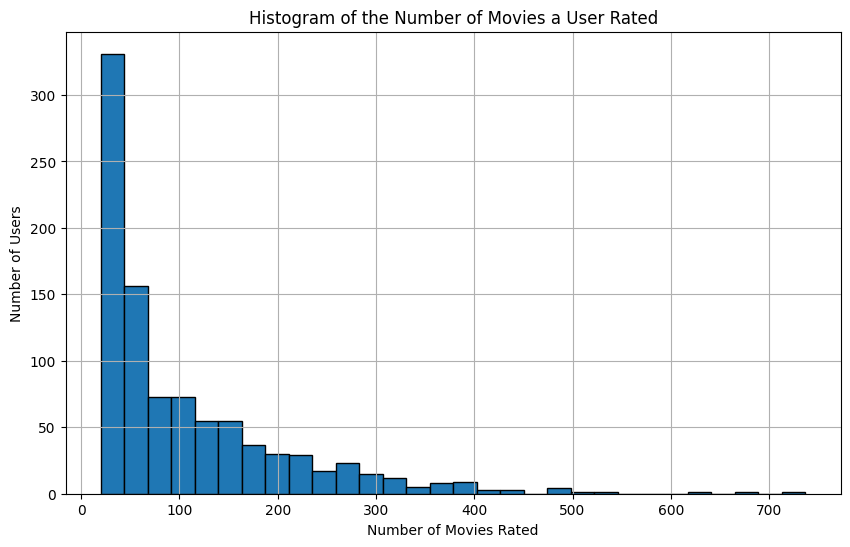

In [2]:
#Part 1a

# Load the data
data = loadmat('movies.mat')
Y = data['Y']  # Rating matrix
R = data['R']  # Indicator matrix for ratings


# Sum along rows of R to get the number of movies each user has rated
user_ratings_count = np.sum(R, axis=0)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(user_ratings_count, bins=30, edgecolor='black')
plt.title("Histogram of the Number of Movies a User Rated")
plt.xlabel("Number of Movies Rated")
plt.ylabel("Number of Users")
plt.grid(True)
plt.show()

In [3]:
#Part 1b

matrix_Y = data['Y']
matrix_R = data['R']

#Using only Y, ignoring zeros
toy_story_ratings = matrix_Y[0, :] 

# Method 1: 
average_rating_Y = np.mean(toy_story_ratings[toy_story_ratings > 0])
print('--'*50)
print('Method 1 Average Rating:', average_rating_Y)
print('--'*50)

# Method 2:
toy_story_ratings_R = matrix_R[0, :] 
toy_story_ratings_RBoolean = toy_story_ratings_R >0 # 
average_rating_Y_Method2 = np.mean(toy_story_ratings[toy_story_ratings_RBoolean]) 

print('--'*50)
print('Method 2 Average Rating:',average_rating_Y_Method2 )
print('--'*50)


----------------------------------------------------------------------------------------------------
Method 1 Average Rating: 3.8783185840707963
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Method 2 Average Rating: 3.8783185840707963
----------------------------------------------------------------------------------------------------


## Part 2--Define the model and cost function

Now we will consider two new matrices: $X$ ($n_m\times n_f$)  and $\Theta$ ($n_u\times n_f$), where $n_f$ is set to be 10 in this problem, which is the number of features. The $X$ matrix represents the features of the movies, e.g., the $i$th row of $X$, $\boldsymbol{x}^{(i)}$ may represent the 10 features, say the degrees of action genre, romance genre, cartoon genre, etc., of the $i$th movie. The $\Theta$ matrix represents the features of the users, e.g., the $j$th row, $\boldsymbol{\theta}^{(j)}$, may represent how much user $j$ is interested in each of the 10 features (genres) of the movies. 

\begin{equation*}
X=\left[\begin{array}{c}
-\left(\boldsymbol{x}^{(1)}\right)^{T}- \\
-\left(\boldsymbol{x}^{(2)}\right)^{T}- \\
\vdots \\
-\left(\boldsymbol{x}^{\left(n_{m}\right)}\right)^{T}-
\end{array}\right], \quad \Theta=\left[\begin{array}{c}
-\left(\boldsymbol{\theta}^{(1)}\right)^{T}- \\
-\left(\boldsymbol{\theta}^{(2)}\right)^{T}- \\
\vdots \\
-\left(\boldsymbol{\theta}^{\left(n_{u}\right)}\right)^{T}-
\end{array}\right]
\end{equation*}

Now we introduce the matrix factorizaton algorithm for collaborative filtering learning. The goal is to learn the values of both the $X$ and $\Theta$ matrices, so that the model predicts the rating for movie $i$ by user $j$ as the dot product of the $i$th row of $X$ and the $j$th row of $\Theta$: $\left(\boldsymbol{x}^{(i)}\right)^T \boldsymbol{\theta}^{(j)}$.

Now we can define the cost function (without regularization) as the residual sum of squares:
\begin{equation*}
J(\boldsymbol{x}^{(1)},\dots,\boldsymbol{x}^{(n_m)},\boldsymbol{\theta}^{(1)},\dots,\boldsymbol{\theta}^{(n_u)}) = \frac{1}{2}\sum_{(i,j):R_{ij}=1}\left(\left(\boldsymbol{x}^{(i)}\right)^T \boldsymbol{\theta}^{(j)}-y_{ij}\right)^2
\end{equation*}
where $\left(\boldsymbol{x}^{(i)}\right)^T \boldsymbol{\theta}^{(j)}-y_{ij}$ represents the difference between the model prediction and the true rating. Note that the sum is only over all of the ratings that are nonzero ($(i,j):R_{ij}=1$).

**Part 2 (10 pts)**: Write a function named cofiCostFunc_v1 (the template is provided below) that calculates the cost function of the collaborative learning algorithm using for loops (non-matrix form). The function computes the cost function value $J$ given $X$ and $\Theta$. Note that $X$ and $\Theta$ are compactly stored in a one-dimensional numpy array *params*, so that the first $n_m\times n_f$ elements of *params* are the values of $X$ and the next $n_u\times n_f$ elements are the values of $\Theta$.

A function named cofiCostFunc is also provided that calculates the cost function in matrix form (which is much faster).

Now test if you can trust the cofiCostFunc_v1 function you have just coded. Load the data file 'movieParams.mat', which contains pretrained $X$ and $\Theta$ matrix. Use the following values for testing:

1. num_users = 4
2. num_movies = 5
3. num_features = 3
4. params = np.concatenate([X[:num_movies,:num_features].flatten(), Theta[:num_users, :num_features].flatten()])

As a result, $Y$, $R$ to be fed into the functions are only part of the original $Y$ and $R$.

For both cofiCostFunc_v1 and cofiCostFunc you should get a value of around $22.22$. If that is what you got, congratulations!

In [4]:
def cofiCostFunc_v1(params, Y, R, num_users, num_movies, num_features, la=0):
    """
    The function using for loops to compute the cost function of the
    collaborative learning algorithm
    Input:
    params: a 1D numpy array of size (n_m times n_f+n_u times n_f,) that stores the values of
            X and Theta at which the cost function will be evaluated
    Y: the Y matrix of size (n_m, n_u) that stores the user ratings
    R: the R indicator matrix of size (n_m, n_u)
    num_users: scalar, the number of users, n_u
    num_movies: scalar, the number of movies, n_m
    num_features: scalar, the number of features n_f
    la: scalar, set to 0 by default, not useful in this function here, 
        but it will be used later for penalized cost function
    
    Return:
    J: a scaler, which is the cost function value
    """
    # first get X and Theta matrix from params
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)

    # Calculating the cost function value using for loop(s)
    J = 0

    for i in range(num_movies):
        for j in range(num_users):
            if R[i, j] == 1: 
                predicted_rating = np.dot(X[i, :], Theta[j, :])
                rating_error = predicted_rating - Y[i, j]
                J += (rating_error ** 2) / 2
    
    
    return J

In [5]:
#Test function
param_data = loadmat('movieParams.mat')
X = param_data['X']
Y = data['Y']
R = data['R']
Theta = param_data['Theta']

# Define the subset parameters
num_users = 4
num_movies = 5
num_features = 3
params = np.concatenate([X[:num_movies,:num_features].flatten(), Theta[:num_users, :num_features].flatten()])

Y_sub = Y[:num_movies,:num_users]
R_sub = R[:num_movies, :num_users]

# Calculate cost
cost_v1 = cofiCostFunc_v1(params, Y_sub, R_sub, num_users, num_movies, num_features)

print('--'*50)
print("Cost calculated by cofiCostFunc_v1:", cost_v1)
print('--'*50)

----------------------------------------------------------------------------------------------------
Cost calculated by cofiCostFunc_v1: 22.22460372568567
----------------------------------------------------------------------------------------------------


In [6]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, la=0):
    """
    The function using matrix form (vectorization) to compute the cost function of the
    collaborative learning algorithm
    Input:
    params: a 1D numpy array of size (n_m times n_f+n_u times n_f,) that stores the values of
            X and Theta at which the cost function will be evaluated
    Y: the Y matrix of size (n_m, n_u) that stores the user ratings
    R: the R indicator matrix of size (n_m, n_u)
    num_users: scalar, the number of users, n_u
    num_movies: scalar, the number of movies, n_m
    num_features: scalar, the number of features n_f
    la: scalar, set to 0 by default, not useful in this function here, 
        but it will be used later for penalized cost function
    
    Return:
    J: a scaler, which is the cost function value
    """
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features) 
    J = 0.5*np.sum((R*X.dot(Theta.T)-Y)**2)
    return J

In [7]:
#Test function 
cost = cofiCostFunc(params, Y_sub, R_sub, num_users, num_movies, num_features)

print('--'*50)
print("Cost calculated by cofiCostFunc_v1:", cost_v1)
print('--'*50)

----------------------------------------------------------------------------------------------------
Cost calculated by cofiCostFunc_v1: 22.22460372568567
----------------------------------------------------------------------------------------------------


## Part 3--Define the gradient function

Again, we do not have a closed-form solution to the problem of minimizing the cost function and we have to use an iterative method, which depends on the gradient with respect to the *params* vector (i.e., all the values in $X$ and $\Theta$).

\begin{equation*}
\begin{aligned}
\frac{\partial J}{\partial x_{k}^{(i)}} &=\sum_{j: r(i, j)=1}\left(\left(\boldsymbol{x}^{(i)}\right)^T\boldsymbol{\theta}^{(j)} -y_{i, j}\right) \theta_{k}^{(j)} \\
\frac{\partial J}{\partial \theta_{k}^{(j)}} &=\sum_{i: r(i, j)=1}\left(\left(\boldsymbol{x}^{(i)}\right)^T\boldsymbol{\theta}^{(j)}-y_{i, j}\right) x_{k}^{(i)}
\end{aligned}
\end{equation*}
where $x_k^{(i)}$ is the $k$th element of $\boldsymbol{x}^{(i)}$, which is also $X[i,k]$, and $\theta_k^{(j)}$ is the $k$th element of $\boldsymbol{\theta}^{(j)}$, which is also $\Theta[j,k]$.

**Part 3 (10 pts)**: A function named cofiGradientFunc is provided that calculates the gradient in matrix form.

Use the function to evaluate the gradient using the parameters given in Part 2. Print out the gradient. To test if you can trust the cofiGradientFunc function, use scipy.optimize.approx_fprime function (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.approx_fprime.html). To run this function, the first paramter xk is the same as params, f is cofiCostFunc, epsilon is 0.001, followed by all of the rest of the parameters needed by cofiCostFunc (i.e., all other than params) in order.

For both cofiGradientFunc and scipy.optimize.approx_fprime you should get similar results, the first three are -2.52899165   7.57570308  -1.89979026. If that is what you got, congratulations again!

In [8]:
def cofiGradientFunc(params, Y, R, num_users, num_movies, num_features, la=0):
    """
    The function using matrix form (vectorization) to compute the gradient 
    of the cost function of the collaborative learning algorithm
    Input:
    params: a 1D numpy array of size (n_m times n_f+n_u times n_f,) that stores the values of
            X and Theta at which the cost function will be evaluated
    Y: the Y matrix of size (n_m, n_u) that stores the user ratings
    R: the R indicator matrix of size (n_m, n_u)
    num_users: scalar, the number of users, n_u
    num_movies: scalar, the number of movies, n_m
    num_features: scalar, the number of features n_f
    la: scalar, set to 0 by default, not useful in this function here, 
        but it will be used later for penalized gradient function
    
    Return:
    J: a 1D numpy array of the same size as params, which is the gradient vector
    """
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)     
    X_grad = (R*(X.dot(Theta.T)-Y)).dot(Theta)
    Theta_grad = (R*(X.dot(Theta.T)-Y)).T.dot(X)
    grad = np.concatenate([X_grad.flatten(), Theta_grad.flatten()])
    return grad

In [9]:
# Define the function
def cost_func_flattened(params, Y, R, num_users, num_movies, num_features):
    return cofiCostFunc(params, Y, R, num_users, num_movies, num_features)

# Compute the analytical gradients
analytical_grad = cofiGradientFunc(params, Y_sub, R_sub, num_users, num_movies, num_features)

# Compute numerical gradients 
epsilon = 0.001
numerical_grad = approx_fprime(params, cost_func_flattened, epsilon, Y_sub, R_sub, num_users, num_movies, num_features)

# Compare the first three elements
print('--'*50)
print("First three elements of Analytical Gradient:", analytical_grad[:3])
print('--'*50)

print('--'*50)
print("First three elements of Numerical Gradient:", numerical_grad[:3])
print('--'*50)


----------------------------------------------------------------------------------------------------
First three elements of Analytical Gradient: [-2.52899165  7.57570308 -1.89979026]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
First three elements of Numerical Gradient: [-2.52882339  7.57722481 -1.8997053 ]
----------------------------------------------------------------------------------------------------


## Part 4--Regularized cost function

Now we will refine the definition of the cost function by adding regularization similar to the Ridge regression. The regularized cost function is defined as:

\begin{equation*}
J(\boldsymbol{x}^{(1)},\dots,\boldsymbol{x}^{(n_m)},\boldsymbol{\theta}^{(1)},\dots,\boldsymbol{\theta}^{(n_u)}) = \frac{1}{2}\sum_{(i,j):R_{ij}=1}\left(\left(\boldsymbol{x}^{(i)}\right)^T \boldsymbol{\theta}^{(j)}-y_{ij}\right)^2 + \left(\frac{\lambda}{2} \sum_{j=1}^{n_{u}} \sum_{k=1}^{n_f}\left(\theta_{k}^{(j)}\right)^{2}\right)+\left(\frac{\lambda}{2} \sum_{i=1}^{n_{m}} \sum_{k=1}^{n_f}\left(x_{k}^{(i)}\right)^{2}\right)
\end{equation*}

**Part 4 (10 pts)**: Write a function named cofiCostFunc_v2 very similar to cofiCostFunc_v1 that calculates the regularized cost function of the collaborative learning algorithm using for loops (non-matrix form). Note that you only need to add the two extra terms in the regularized cost function. The la variable defined in the codes above represents the $\lambda$ value.

A function named cofiCostFunc_Regularized is also provided that calculates the cost function in matrix form.

Now test if you can trust the cofiCostFunc_v2 function you have just coded as what you did in Part2. Use $la=1.5$. 

For both cofiCostFunc_v2 and cofiCostFunc_Regularized you should get a value of around $31.34$. If that is what you got, congratulations!

In [10]:
def cofiCostFunc_Regularized(params, Y, R, num_users, num_movies, num_features, la=1.5):
    """
    The function using matrix form (vectorization) to compute the penalized
    cost function of the collaborative learning algorithm
    
    Input:
    params: a 1D numpy array of size (n_m times n_f+n_u times n_f,) that stores the values of
            X and Theta at which the penalized cost function will be evaluated
    Y: the Y matrix of size (n_m, n_u) that stores the user ratings
    R: the R indicator matrix of size (n_m, n_u)
    num_users: scalar, the number of users, n_u
    num_movies: scalar, the number of movies, n_m
    num_features: scalar, the number of features n_f
    la: scalar, the penalization coefficient
    
    Return:
    J: scalar, the penalized cost function
    """
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)     
    J = 0.5*np.sum((R*X.dot(Theta.T)-Y)**2)  
    
    J = J + la/2*(np.sum(X**2) + np.sum(Theta**2))
    
    return J

In [11]:
#Make function
def cofiCostFunc_v2(params, Y, R, num_users, num_movies, num_features, la=1.5):
  
    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)
    
    J = 0
    # Calculate the cost with regularization
    for i in range(num_movies):
        for j in range(num_users):
            if R[i, j] == 1:
                prediction = np.dot(X[i, :], Theta[j, :])
                error = prediction - Y[i, j]
                J += (error ** 2) / 2
    
    # Add regularization terms
    reg_X = la / 2 * np.sum(X**2)
    reg_Theta = la / 2 * np.sum(Theta**2)
    J += reg_X + reg_Theta
    
    return J


In [12]:
#test

# Compute the regularized cost using both functions
cost_v2 = cofiCostFunc_v2(params, Y_sub, R_sub, num_users, num_movies, num_features)
cost_reg = cofiCostFunc_Regularized(params, Y_sub, R_sub, num_users, num_movies, num_features)

print('--'*50)
print("Cost from cofiCostFunc_v2:", cost_v2)
print('--'*50)

print('--'*50)
print("Cost from cofiCostFunc_Regularized:", cost_reg)
print('--'*50)


----------------------------------------------------------------------------------------------------
Cost from cofiCostFunc_v2: 31.344056244274213
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Cost from cofiCostFunc_Regularized: 31.34405624427422
----------------------------------------------------------------------------------------------------


## Part 5--Regularized gradient

Similar to Part 3, we now can find the gradient with respect to the *params* vector (i.e., all the values in $X$ and $\Theta$) for the penalized cost function.

\begin{equation*}
\begin{aligned}
\frac{\partial J}{\partial x_{k}^{(i)}} &=\sum_{j: r(i, j)=1}\left(\left(\boldsymbol{x}^{(i)}\right)^T\boldsymbol{\theta}^{(j)} -y_{i, j}\right) \theta_{k}^{(j)} +\lambda x_k^{(i)}\\
\frac{\partial J}{\partial \theta_{k}^{(j)}} &=\sum_{i: r(i, j)=1}\left(\left(\boldsymbol{x}^{(i)}\right)^T\boldsymbol{\theta}^{(j)}-y_{i, j}\right) x_{k}^{(i)} +\lambda \theta_k^{(j)}
\end{aligned}
\end{equation*}

**Part 5 (10 pts)**: A function named cofiGradientFunc_Regularized is provided that calculates the regularized gradient in matrix form.

Use the function to evaluate the gradient as in Part 3 with $la=1.5$. Print out the gradient. Use the scipy.optimize.approx_fprime function again to verify the results.

The first three gradient values should be -0.95596339,   6.97535514,  -0.10861109. If that is what you got, let's move on!

In [13]:
def cofiGradientFunc_Regularized(params, Y, R, num_users, num_movies, num_features, la=1.5):
    """
    The function using matrix form (vectorization) to compute the gradient 
    of the penalized cost function of the collaborative learning algorithm
    
    Input:
    params: a 1D numpy array of size (n_m times n_f+n_u times n_f,) that stores the values of
            X and Theta at which the gradient will be evaluated
    Y: the Y matrix of size (n_m, n_u) that stores the user ratings
    R: the R indicator matrix of size (n_m, n_u)
    num_users: scalar, the number of users, n_u
    num_movies: scalar, the number of movies, n_m
    num_features: scalar, the number of features n_f
    la: scalar, the penalization coefficient
    
    Return:
    grad : a 1D numpy array of the same size as params, which is the gradient vector
    """
    X = params[:num_movies*num_features].reshape(num_movies, num_features)
    Theta = params[num_movies*num_features:].reshape(num_users, num_features)     
    X_grad = (R*(X.dot(Theta.T)-Y)).dot(Theta)
    Theta_grad = (R*(X.dot(Theta.T)-Y)).T.dot(X)    
    
    X_grad = X_grad + la*X  
    Theta_grad = Theta_grad + la*Theta
    
    grad = np.concatenate([X_grad.flatten(), Theta_grad.flatten()])
    return grad

In [14]:

# Define the function
def cost_func_reg(params, Y, R, num_users, num_movies, num_features):
    return cofiCostFunc_Regularized(params, Y, R, num_users, num_movies, num_features)

# Compute the analytical gradients
analytical_grad = cofiGradientFunc_Regularized(params, Y_sub, R_sub, num_users, num_movies, num_features)

# Compute numerical gradients 
epsilon = 0.001

numerical_grad = approx_fprime(params,cost_func_reg , epsilon, Y_sub, R_sub, num_users, num_movies, num_features)

print('--'*50)
print("Analytical Gradient:\n", analytical_grad[:3])
print('--'*50)

print('--'*50)
print("Numerical Gradient:\n", numerical_grad[:3])
print('--'*50)

----------------------------------------------------------------------------------------------------
Analytical Gradient:
 [-0.95596339  6.97535514 -0.10861109]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Numerical Gradient:
 [-0.95504514  6.97762687 -0.10777613]
----------------------------------------------------------------------------------------------------


## Part 6--Add your own ratings

Now let's add our own ratings to some randomly picked movies. Suppose we give a 4 star to the first movie, a 2 star to the 98th movie, add so on. Here is the code:

In [15]:
n_m = Y.shape[0]
my_ratings = np.zeros(n_m)
my_ratings[0] = 4
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11] = 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

We can see what the movie names are by load the 'movie_ids.txt' file:

In [16]:
with open('movie_ids.txt', encoding="ISO-8859-1") as f:
    movies = f.readlines()

In [17]:
# See the information of the first and 7th movies:
print(movies[0])
print(movies[6])

1 Toy Story (1995)

7 Twelve Monkeys (1995)



**Part 6a (5 pts)**: Print out (with a for loop) a summary of what you just rated so that it looks like:

Rated  4.0  for  Toy Story (1995)

Rated  3.0  for  Twelve Monkeys (1995)

Rated  5.0  for  Usual Suspects, The (1995)

Rated  4.0  for  Outbreak (1995)

Rated  5.0  for  Shawshank Redemption, The (1994)

Rated  3.0  for  While You Were Sleeping (1995)

Rated  5.0  for  Forrest Gump (1994)

Rated  2.0  for  Silence of the Lambs, The (1991)

Rated  4.0  for  Alien (1979)

Rated  5.0  for  Die Hard 2 (1990)

Rated  5.0  for  Sphere (1998)

In [18]:
index = np.nonzero(my_ratings)[0] 

for i in index:
    movie_info = movies[i].split(' ', 1) 
    if len(movie_info) > 1: 
        movie_title = movie_info[1].strip() 
    else: 
        movie_title = movie_info[0].strip() 
    print(f'Rated {my_ratings[i]:.1f} for {movie_title}')


Rated 4.0 for Toy Story (1995)
Rated 3.0 for Twelve Monkeys (1995)
Rated 5.0 for Usual Suspects, The (1995)
Rated 4.0 for Outbreak (1995)
Rated 5.0 for Shawshank Redemption, The (1994)
Rated 3.0 for While You Were Sleeping (1995)
Rated 5.0 for Forrest Gump (1994)
Rated 2.0 for Silence of the Lambs, The (1991)
Rated 4.0 for Alien (1979)
Rated 5.0 for Die Hard 2 (1990)
Rated 5.0 for Sphere (1998)


**Part 6b (5 pts)**: Concatenate your ratings to the $Y$ matrix (as the last column) and concatenate a column to the $R$ matrix too (still as the last column), so $R$ now recorded  what movies you rated. For example, the first elment in the last column of $R$ should be a 1, because you rated the first movie. You should have only eleven 1's in the last column of R and all the others are 0's. Similar for $Y$, you should have only eleven nonzeros in the last column. Now, both your $Y$ and $R$ matrix has a shape of (1682, 944).

Make a scatter plot of the last column of $Y$ and $R$ separately (against the indices 0,1,...1681). It helps you check if you added the correct columns to $Y$ and $R$.

New shape of Y matrix: (1682, 944)
New shape of R matrix: (1682, 944)


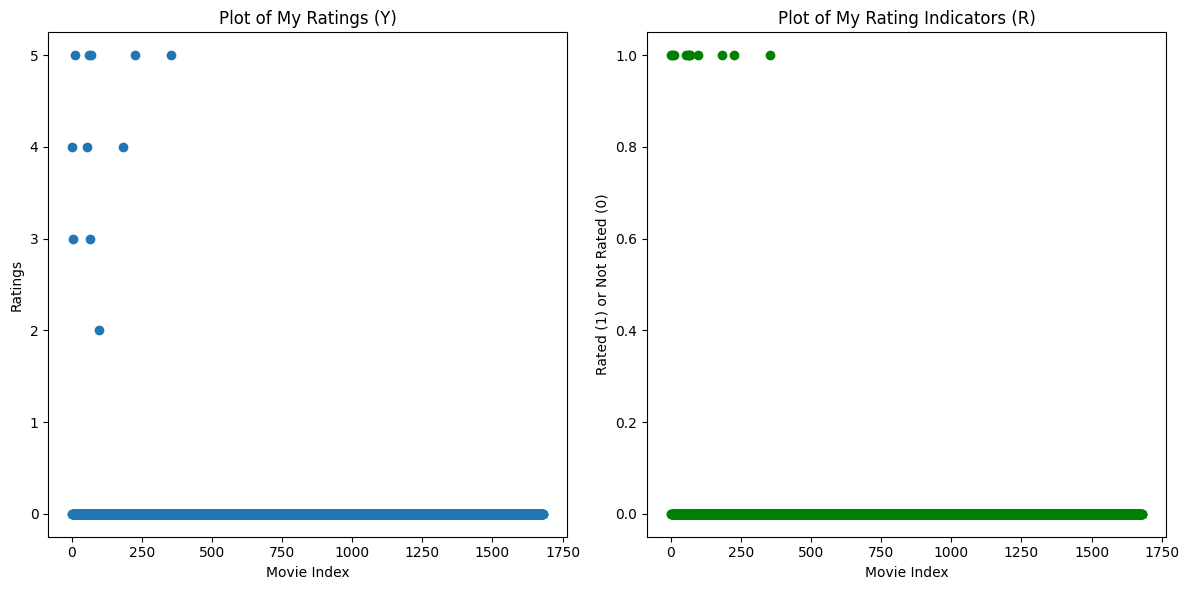

In [19]:
#Part 6b
# Create the R column 
my_rated = (my_ratings > 0).astype(int)

# Expand dimensions of my_ratings and my_rated to be column vectors
my_ratings = np.expand_dims(my_ratings, axis=1)
my_rated = np.expand_dims(my_rated, axis=1)

# Concatenate 
Y = np.hstack((Y, my_ratings))
R = np.hstack((R, my_rated))

# Print the new shapes to verify
print("New shape of Y matrix:", Y.shape)
print("New shape of R matrix:", R.shape)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(range(Y.shape[0]), Y[:, -1])
plt.title("Plot of My Ratings (Y)")
plt.xlabel("Movie Index")
plt.ylabel("Ratings")

plt.subplot(1, 2, 2)
plt.scatter(range(R.shape[0]), R[:, -1], c='green')
plt.title("Plot of My Rating Indicators (R)")
plt.xlabel("Movie Index")
plt.ylabel("Rated (1) or Not Rated (0)")

plt.tight_layout()
plt.show()

## Part 7--Preprocessing the data: mean-normalize $Y$

We are very close to training the model on the entire data: $Y$ and $R$! One more step before that is to preprocess the rating data $Y$. We will perform the mean-normalization for $Y$: for each row of $Y$, find the row mean and subtract it from every nonzero number of the row. For example, if a row is $[3, 4, 5, 0]$, the row mean is (3+4+5)/3 = 4 (not counting 0), and mean-normalizing the row will give us $[-1, 0, 1, 0]$ (again 0 is not touched).

You have found the row mean in Part 1 for the first row, so it should be straightforward to find the row means for all rows. Then the mean-normalization should be easier. 

Doing this makes more sense for the users who did not provide any ratings. For a user who did not make any ratings, the model based on the mean-normalized data will use the mean of all the other users' ratings to an movie as the prediction for the user on the movie, while the model based on the original data will use 0.

**Part 7 (10 pts)**: A function template is provided below for performing mean-normalization. Complete the function, use np.sum to check the row sums after you get the mean-normalized $Y$ to see if you get all 0's (or very small numbers).

In [20]:
def mean_normalize(Y, R):
    """
    Perform mean-normalization for Y
    Input:
    Y: 2D numpy array of shape (1682, 944), the original ratings (with the newly 
       added ratings by you)
    R: 2D numpy array of shape (1682, 944), the indicator matrix. NOTE that you may not need
       to use R to mean-normalize Y. If you don't use it, that's fine too.
    Return:
    Y_mean: 1d array of shape (num_movies=1682), the row means of Y
    Y_normalized: 2d array of the same shape as Y, the mean-normalized Y.    
    """
    
    # make a copy of Y to prevent you directly changing Y, which will change the original data.
    # Do not change the original R either in this function
    Y_normalized = Y.copy()
    # Now complete the function

    Y_mean = np.zeros(Y.shape[0])
    
    # Loop through each movie
    for i in range(Y.shape[0]):
        # Find indices where the movie has been rated
        idx = R[i, :] == 1
        # Calculate the mean for rated movies
        if np.sum(idx) > 0:
            
            Y_mean[i] = np.mean(Y[i, idx])
            Y_normalized[i, idx] = Y_normalized[i, idx] - Y_mean[i] 

        else: # If no ratings
            Y_mean[i] = 0 

    
    return Y_mean, Y_normalized

In [21]:
#Test

Y_mean, Y_normalized = mean_normalize(Y, R)

print('--'*50)
print("Row sums of normalized Y :", np.sum(Y_normalized, axis=1))
print('--'*50)

----------------------------------------------------------------------------------------------------
Row sums of normalized Y : [-2.35367281e-14 -8.88178420e-16  1.06581410e-14 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
----------------------------------------------------------------------------------------------------


## Part 8--Train the model

Now we are fully ready to train the model. We can well use a familiar gradient descent solver; however, we will try a new solver: scipy.optimize.fmin_cg (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_cg.html), which is a conjugate gradient optimizer. 

We first set the correct parameters, and initialize $X$ and $\Theta$ with the following code. Note that here we use Gaussian (normal) random numbers to initialize the values of $X$ and $\Theta$. We set the seed of the random number generator to 10 so everyone should get the same result. Then we put all the values in $X$ and $\Theta$ in a 1D array as we did before, so we have the initial guess. We will let the conjugate gradient optimizer learn the values of $X$ and $\Theta$. We use a $\lambda$ of $10$.

In [22]:
# Set the correct parameters (constant values)
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10
# initial values of X and Theta
np.random.seed(10)
X = np.random.normal(size=(num_movies, num_features))
Theta = np.random.normal(size=(num_users, num_features))
initial_guess = np.concatenate([X.flatten(), Theta.flatten()])
la = 10

**Part 8a (5 pts)** Find the initial cost function value based on the initial guess by calling the cofiCostFunc_Regularized function. Report the initial cost, which should be around $669101$. If you got the result, great!

In [23]:
#Part 8a
# Calculate the initial cost
initial_cost = cofiCostFunc_Regularized(initial_guess, Y_normalized, R, num_users, num_movies, num_features, la)

print('--'*50)
print("Initial Cost:", initial_cost)
print('--'*50)

----------------------------------------------------------------------------------------------------
Initial Cost: 669101.3614292007
----------------------------------------------------------------------------------------------------


**Part 8b (5pts)** Run the fmin_cg optimizer by telling the function about the cost function, initial guess, gradient function, the rest of the parameters needed to be provided to the cost function and gradient function, as follows. You should get a minimized cost function value of around $38951$, which is much smaller than the original cost. The optimal parameter values are now stored in result.

In [24]:
# Start training
result = fmin_cg(cofiCostFunc_Regularized, initial_guess, 
                 cofiGradientFunc_Regularized, 
                 args=(Y_normalized, R, num_users, num_movies, num_features, la))

Optimization terminated successfully.
         Current function value: 38951.847560
         Iterations: 338
         Function evaluations: 500
         Gradient evaluations: 500


## Part 9--Make movie recommendations to yourself! 

Note the values of the matrices $X$ and $\Theta$ are stored in the 'result' variable. The first num_movies*num_features values of 'result' are the entries of $X$; the rest of the values are the entries of $\Theta$. Perform the following steps:

1. Obtain the $X$ and $\Theta$ matrices

2. The predictions for all users and all movies are given by $P= X\cdot \Theta^T$, the product of $X$ and the transpose of $\Theta$. Note that the prediction matrix $P$ is of shape (num_movies by num_users), where the (i,j) entry of P represents the prediction of the rating to movie i by user j.

3. Now you are interested in knowning what the predicted ratings to all the movies are for you. So you only need the last column (which is related to you) of $P$. Extract the last column of $P$, and we call it p_user. We also need to add back the Y_mean vector to p_user; otherwise, the predicted ratings are mean-normalized. After you add Y_mean back, now p_user will be in the 1 to 5 range.

4. Now find the top 20 movies based on the 20 largest values of p_user. Those will be the movies to be recommended to you! Print out the 20 movies along with the predicted ratings in p_user, something like: 

Recommending movie  Schindler's List (1993)  based on rating  4.36

and so on.

The movie with the largest rating should be printed out first. np.argmax will help again! (**15 pts for Part 9**)

In [25]:
# Step 1
num_movies = Y.shape[0]
num_users = Y.shape[1]
num_features = 10

# Extract X and Theta from the result
X = result[:num_movies * num_features].reshape(num_movies, num_features)
Theta = result[num_movies * num_features:].reshape(num_users, num_features)

# Step 2
P = X.dot(Theta.T)

# Step 3
p_user = P[:, -1]  

# Add back the mean to get the actual rating predictions
p_user = p_user + Y_mean

# Step 4
# Get the top 20 movies recommended for you
top_20_idx = np.argsort(p_user)[-20:][::-1]  # Indices of top 20 ratings in descending order


top_ratings = p_user[top_20_idx] # Top 20 ratings for the user

print("Top 20 movie recommendations for you:")
for index, movie_index in enumerate(top_20_idx):
    movie_info = movies[movie_index].split(' ', 1) 
    movie_title = movie_info[1].strip()
    movie_rating = top_ratings[index]
    print(f"Recommending movie {movie_title} based on rating {movie_rating:.1f}")


Top 20 movie recommendations for you:
Recommending movie Star Kid (1997) based on rating 5.0
Recommending movie Someone Else's America (1995) based on rating 5.0
Recommending movie Entertaining Angels: The Dorothy Day Story (1996) based on rating 5.0
Recommending movie Prefontaine (1997) based on rating 5.0
Recommending movie Great Day in Harlem, A (1994) based on rating 5.0
Recommending movie Marlene Dietrich: Shadow and Light (1996) based on rating 5.0
Recommending movie Saint of Fort Washington, The (1993) based on rating 5.0
Recommending movie Santa with Muscles (1996) based on rating 5.0
Recommending movie They Made Me a Criminal (1939) based on rating 5.0
Recommending movie Aiqing wansui (1994) based on rating 5.0
Recommending movie Pather Panchali (1955) based on rating 4.6
Recommending movie Star Wars (1977) based on rating 4.6
Recommending movie Shawshank Redemption, The (1994) based on rating 4.6
Recommending movie Maya Lin: A Strong Clear Vision (1994) based on rating 4.5
Re

## Side note
We can now recommend movies for any users! We should actually recommend the movies a user did not rate. The printed list above has some movies you rated. But that's OK. You now know how to build a recommender system with the collaborative filtering algorithm. Congratulations!

The method is called matrix factorization, because it is similar to finding the matrix factorization of $Y$ in the form of $X\cdot\Theta^T$.

## Part 10 User-User Collaborative Filtering by K-Nearest Neighbors 

You have done a lot for the project and I would not let you spend much time on this one! The goal is to understand the idea of another collaborative filtering algorithm and run the codes I wrote! 

The algorithm is called User-User Collaborative Filtering. The idea is: suppose you did not rate the 5th movie, but a lot of many other users did. Then we would like to predict your rating to the 5th movie based on the ratings to the movie given by say 10 other users who are most similar to you. For example, we can use the average of the ratings given by 10 other most similar users. To measure the similarity of two users, we usually use the cosine similarity (distance). The cosine similarity of the $i$th column of $Y$ and the $j$th column of $Y$ (after centering) would  give us the similarity of the $i$th user and the $j$th user. So this is actually a K-nearest neighbor problem.

Here is the code for the implentation of the user-user collaborative filtering:

In [26]:
def KNNCofi(K, Y, R, movie_n, Y_col_mean):
    """
    Find the K nearest neighbors of the user with ratings of the movie_n th movie 
    """
    data = Y[:, R[movie_n,:].astype(bool)] 
    if data.shape[1] >= K:
        knn = NearestNeighbors(metric='cosine', algorithm='brute', 
                               n_neighbors=K, n_jobs=-1)
    else:
        knn = NearestNeighbors(metric='cosine', algorithm='brute', 
                               n_neighbors=data.shape[1], n_jobs=-1)
    knn.fit(data.T)
    neigh_dist, neigh_ind = knn.kneighbors(np.reshape(Y[:, -1], (1, num_movies)))
    # rating_pred = np.dot(neigh_dist[0,:], data[movie_n, neigh_ind[0,:]])/(np.sum(neigh_dist[0,:]))
    rating_pred = np.mean(data[movie_n, neigh_ind[0,:]]+Y_col_mean[R[movie_n,:].astype(bool)][neigh_ind[0,:]])
    return rating_pred

def UserUserCofi(Y, R, K=9):
    """
    Y: 2D numpy array of shape (1682, 944), the original ratings (with the newly 
       added ratings by you)
    R: 2D numpy array of shape (1682, 944), the indicator matrix. NOTE that you may not need
       to use R to mean-normalize Y. If you don't use it, that's fine too.
    K: integer, specify the how many nearest neighbors to use
    Return:
    ratings_pred: 1D array of size num_movies, the predicted ratings for all 
                the movie the user did not rate. For the movies, the user has
                predicted, the value in ratings_pred will be zero
    """
    Y_col_normalized = Y.copy()
    Y_col_mean = np.zeros(Y.shape[1])
    for i in range(Y.shape[1]):
        Y_col_mean[i] = np.mean(Y[R[:, i].astype(bool), i])
        Y_col_normalized[R[:, i].astype(bool), i] = Y[R[:, i].astype(bool), i] - Y_col_mean[i]
    
    ratings_pred = np.zeros(Y.shape[0])
    for i in range(Y.shape[0]):
        if (R[i,-1] == 0):
            ratings_pred[i] = KNNCofi(K, Y_col_normalized, R, i, Y_col_mean)
    return ratings_pred

Just call UserUserCofi with the default K value to obtain the predicted ratings and print out the top 20 movies, similar to what you did in Part 9. Check if there are common movies (you don't need to answer this). **5 pts for Part 10**. 

In [27]:
predicted_ratings = UserUserCofi(Y, R)
predicted_20 = np.argsort(predicted_ratings)[-20:][::-1]
User_20 = predicted_ratings[predicted_20]

print("Top 20 movie recommendations for you:")
for index, movie_index in enumerate(predicted_20):
    movie_info = movies[movie_index].split(' ', 1)
    movie_title = movie_info[1].strip()
    movie_rating = User_20[index]
    print(f"Recommended movie {movie_title} based on rating {movie_rating:.1f}")

Top 20 movie recommendations for you:
Recommended movie Saint of Fort Washington, The (1993) based on rating 5.0
Recommended movie They Made Me a Criminal (1939) based on rating 5.0
Recommended movie Entertaining Angels: The Dorothy Day Story (1996) based on rating 5.0
Recommended movie Marlene Dietrich: Shadow and Light (1996) based on rating 5.0
Recommended movie Great Day in Harlem, A (1994) based on rating 5.0
Recommended movie Prefontaine (1997) based on rating 5.0
Recommended movie Aiqing wansui (1994) based on rating 5.0
Recommended movie Star Kid (1997) based on rating 5.0
Recommended movie Santa with Muscles (1996) based on rating 5.0
Recommended movie Someone Else's America (1995) based on rating 5.0
Recommended movie Close Shave, A (1995) based on rating 4.9
Recommended movie Star Wars (1977) based on rating 4.8
Recommended movie Some Folks Call It a Sling Blade (1993) based on rating 4.7
Recommended movie As Good As It Gets (1997) based on rating 4.7
Recommended movie Three

## Ending

I know it has been quite a journey to work on this final project, but I am sure you have learned some techniques that even Netflix, Amazon, etc. are using (of course more complex versions). Best luck to you as you move onto the next stage in your machine learning journey!